##Importing required datasets

In [1]:
import matplotlib.pyplot as plt
import keras 
from keras.datasets import mnist
import numpy as np

##Viewing an image in the dataset

11501568/11490434 [==============================] - 0s 0us/step


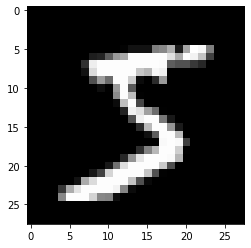

In [2]:
(X_train, _), (_, _) = mnist.load_data()
plt.imshow(X_train[0],cmap='gray')
plt.show()

##Viewing the 1st 9 images

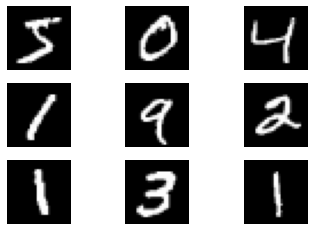

In [3]:
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.axis('off')
  plt.imshow(X_train[i],cmap='gray')
plt.show()

##Creating our discriminator function

In [4]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

In [5]:
def discriminator(input_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same',input_shape=input_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(lr=0.0001, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [6]:
model=discriminator()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


##Function for loading real samples

In [7]:
def real_samples():
  (X_train, _), (_, _) = mnist.load_data()
  X = np.expand_dims(X_train, axis=-1)
  X = X.astype('float32')
  X = X / 255.0
  return X

In [8]:
def generate_real_samples(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1))
	return X, y

In [9]:
def generate_fake_samples(n_samples):
	X = np.random.rand(28 * 28 * n_samples)
	X = X.reshape((n_samples, 28, 28, 1))
	y = np.zeros((n_samples, 1))
	return X, y

In [10]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	for i in range(n_iter):
		X_real, y_real = generate_real_samples(dataset, half_batch)
		_, real_acc = model.train_on_batch(X_real, y_real)
		X_fake, y_fake = generate_fake_samples(half_batch)
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [11]:
model = discriminator()
dataset = real_samples()
train_discriminator(model, dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


>1 real=27% fake=52%
>2 real=28% fake=58%
>3 real=38% fake=68%
>4 real=41% fake=71%
>5 real=36% fake=76%
>6 real=32% fake=84%
>7 real=42% fake=88%
>8 real=34% fake=88%
>9 real=36% fake=97%
>10 real=42% fake=97%
>11 real=40% fake=100%
>12 real=45% fake=100%
>13 real=36% fake=98%
>14 real=34% fake=99%
>15 real=38% fake=99%
>16 real=34% fake=100%
>17 real=41% fake=100%
>18 real=35% fake=100%
>19 real=33% fake=100%
>20 real=48% fake=100%
>21 real=40% fake=100%
>22 real=42% fake=100%
>23 real=38% fake=100%
>24 real=44% fake=100%
>25 real=45% fake=100%
>26 real=45% fake=100%
>27 real=47% fake=100%
>28 real=47% fake=100%
>29 real=50% fake=100%
>30 real=56% fake=100%
>31 real=50% fake=100%
>32 real=57% fake=100%
>33 real=59% fake=100%
>34 real=60% fake=100%
>35 real=56% fake=100%
>36 real=62% fake=100%
>37 real=66% fake=100%
>38 real=84% fake=100%
>39 real=75% fake=100%
>40 real=74% fake=100%
>41 real=82% fake=100%
>42 real=77% fake=100%
>43 real=82% fake=100%
>44 real=89% fake=100%
>45 real=9

##Defining the generator model

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
def generator(latent_dim):
	model = Sequential()
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [13]:
latent_dim = 100
model = generator(latent_dim)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 128)      

In [14]:
def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [15]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	y = np.zeros((n_samples, 1))
	return X, y

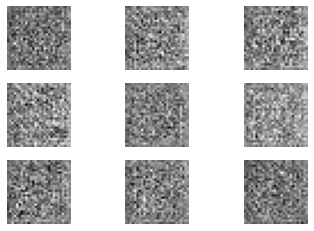

In [16]:
latent_dim = 100
model = generator(latent_dim)
n_samples = 9
X, _ = generate_fake_samples(model, latent_dim, n_samples)
for i in range(n_samples):
	plt.subplot(3,3, 1 + i)
	plt.axis('off')
	plt.imshow(X[i, :, :, 0], cmap='gray_r')
plt.show()

##Training the generator

In [17]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(lr=0.0001, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [18]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


##Training the GAN

In [19]:
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	for i in range(n_epochs):
		x_gan = generate_latent_points(latent_dim, n_batch)
		y_gan = ones((n_batch, 1))
		gan_model.train_on_batch(x_gan, y_gan)

In [20]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			d_loss, _ = d_model.train_on_batch(X, y)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

In [24]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [22]:
from numpy import vstack
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			d_loss, _ = d_model.train_on_batch(X, y)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [25]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Streaming output truncated to the last 5000 lines.
>79, 155/234, d=0.695, g=0.701
>79, 156/234, d=0.693, g=0.712
>79, 157/234, d=0.691, g=0.720
>79, 158/234, d=0.679, g=0.716
>79, 159/234, d=0.686, g=0.703
>79, 160/234, d=0.686, g=0.717
>79, 161/234, d=0.692, g=0.713
>79, 162/234, d=0.691, g=0.710
>79, 163/234, d=0.700, g=0.705
>79, 164/234, d=0.694, g=0.693
>79, 165/234, d=0.685, g=0.688
>79, 166/234, d=0.685, g=0.696
>79, 167/234, d=0.697, g=0.708
>79, 168/234, d=0.683, g=0.702
>79, 169/234, d=0.690, g=0.702
>79, 170/234, d=0.689, g=0.702
>79, 171/234, d=0.686, g=0.708
>79, 172/234, d=0.692, g=0.712
>79, 173/234, d=0.686, g=0.711
>79, 174/234, d=0.689, g=0.714
>79, 175/234, d=0.694, g=0.709
>79, 176/234, d=0.692, g=0.716
>79, 177/234, d=0.687, g=0.701
>79, 178/234, d=0.682, g=0.707
>79, 179/234, d=0.691, g=0.722
>79, 180/234, d=0.692, g=0.694
>79, 181/234, d=0.688, g=0.691
>79, 182/234, d=0.677, g=0.695
>79, 183/234, d=0.687, g=0.715
>79, 184/234, d=0.694, g=0.725
>79, 185/234, d=0.7

##Prediction on an array of 1's after 10 epochs:

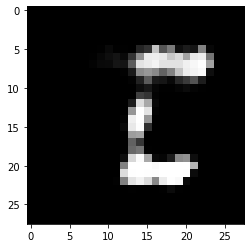

In [42]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
model = load_model('/content/generator_model_010.h5')
vector = asarray([[1.0 for _ in range(100)]])
X = model.predict(vector)
pyplot.imshow(X[0, :, :, 0], cmap='gray')
pyplot.show()

##Prediction on an array of 1's after 20 epochs:

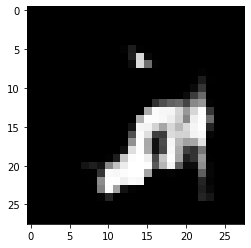

In [45]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
model = load_model('/content/generator_model_020.h5')
vector = asarray([[1.0 for _ in range(100)]])
X = model.predict(vector)
pyplot.imshow(X[0, :, :, 0], cmap='gray')
pyplot.show()

##Prediction on an array of 1's after a 100 epochs:

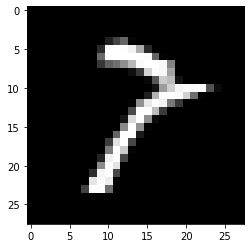

In [41]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
model = load_model('/content/generator_model_100.h5')
vector = asarray([[1.0 for _ in range(100)]])
X = model.predict(vector)
pyplot.imshow(X[0, :, :, 0], cmap='gray')
pyplot.show()